In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
from src.env.dunderbot_env import DunderBotEnv
import src.run as run
import src.load as load

loading config from config/config.yml
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



# TODO:

- figure out how to normalize values properly
    * do we have to account for prediction as well? That is, can/should we predict using values outside of 0-1 range?
- normalize the action space?
- understand the rendering, especially during learning
- Change policy network (need to understand terminology surronding it, e.g. envoronment, n_steps etc). See also discussion here (and elsewhere among Issues: https://github.com/hill-a/stable-baselines/issues/759)
- setup train/test functionality (separate reset functions? Multiple time periods for testing?)
- Check/Enable/Add exploration noise (for PPO2, use the entropy flag)
- lock down the seeds (and decide in config from a few specific ones)
- setup performance output, what we need to make data driven decision
    *e.g. https://colab.research.google.com/github/araffin/rl-tutorial-jnrr19/blob/master/1_getting_started.ipynb#scrollTo=63M8mSKR-6Zt
- Add benchmarks
- Add checks and tests
- Find as long time series of BTCUSD hourly data as possible, quite shortright now
- Add finer temporal resolution in data (generate/download multiple granularity)
- Check float number type
- self.stationarize_rewards?
- Enable saveing/loading trained models


# DONE: 
- add config
- modularize rewards
- own actions
- add more detailed actions for buy and sell amounts (still Discrete, I believe)
- wrap running code in function in main.py (to enable more dynamic data loading and train/test)
- own observations
- remove the bias when getting the observations (suggestion in the repo issues)
- download more interesting data and manually preprocess
- load interesting data, specified in config
- understand the time steps in learn and predict
- setup basic monitoring of training using TensorBoard
- Visualize basic performance
- Add support for fractions of shares
- Understand what should belong in what timestep (also decide on which price to plot as a result)
- add distributions of actions as output during prediction
- Refactor `_take_action` (might be something off in some calculations, also update terminology)
- Add commission and slippage
- Refactor current reward and add some new ones
- Add smallest amount of bitcoin we can own, as well as trading precision
- Add portfolio features
- Add reward output

# Run

In [3]:
%%time
df = load.load_OHLC_data()
env = run.preprocess(df=df)
model = run.train(env=env, total_timesteps=10000)





Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




--------------------------------------
| approxkl           | 6.1062137e-06 |
| clipfrac           | 0.0           |
| explained_variance | 0.0509        |
| fps                | 110           |
| n_updates          | 1             |
| policy_entropy     | 2.1972191     |
| policy_loss        | -0.0008149238 |
| serial_timesteps   | 128           |
| time_elapsed       | 0.000265      |
| total_timesteps    | 128           |
| value_loss         | 3.2840966e-05 |
--------------------------------------
--------------------------------------
| approxkl           | 8.572768e-05  |
| clipfrac           | 0.0           |
| explained_variance | 0.018         |
| fps                | 108           |
| n_updates          | 10            |
| policy_entropy    

CPU times: user 1min 28s, sys: 3.9 s, total: 1min 31s
Wall time: 1min 27s


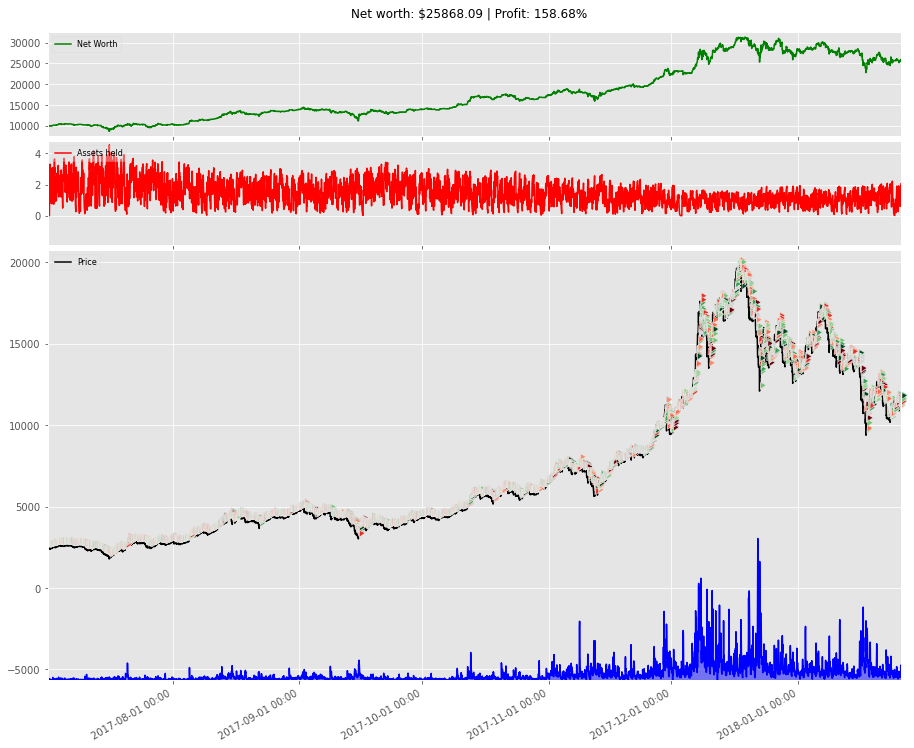

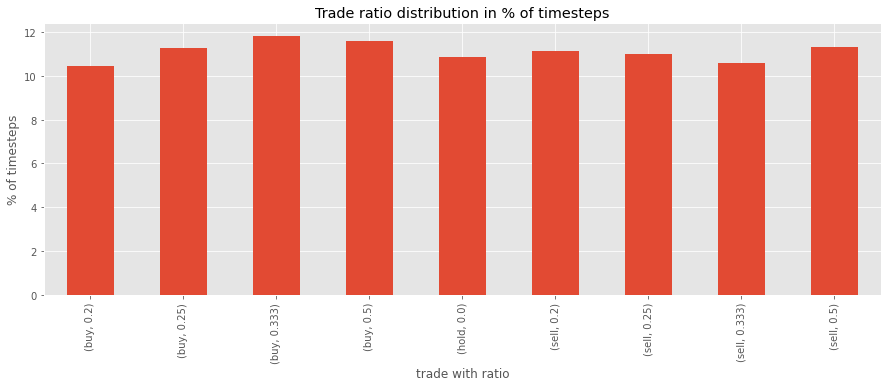

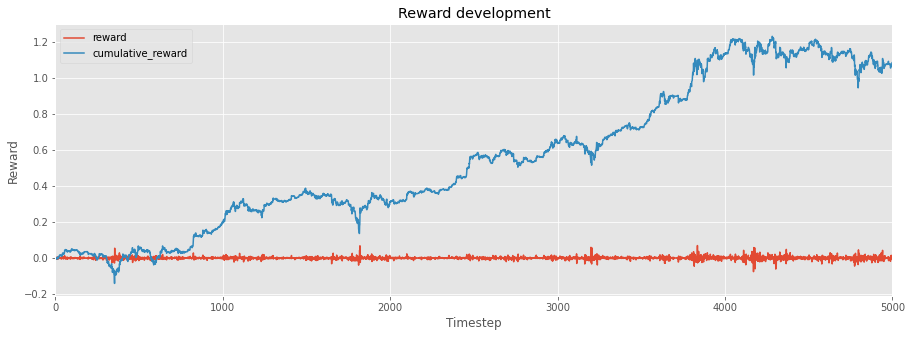

CPU times: user 3min 12s, sys: 7.32 s, total: 3min 19s
Wall time: 3min 18s


In [5]:
%%time
run.predict(env=env, model=model, total_timesteps=5000, rendermode='human')

In [5]:
import pickle
with open('all_dict_pred.pickle', 'rb') as f:
    x = pickle.load(f)
x

{'current_step': 59,
 'net_worths': [10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10017.38,
  10039.08,
  10035.03,
  9964.04,
  9996.28,
  9991.3,
  9983.6,
  10006.07,
  10102.31,
  10035.7,
  10065.79,
  10171.4,
  10159.67,
  10121.92,
  10152.2,
  10142.43,
  10138.52,
  10156.61,
  10219.68,
  10261.13,
  10331.26,
  10313.58,
  10321.81,
  10351.71,
  10378.93,
  10370.6,
  10369.87,
  10343.92,
  10343.11,
  10339.55,
  10339.44,
  10340.77,
  10339.26,
  10345.53,
  10306.84,
  10312.43,
  10319.94,
  10313.41,
  10364.82,
  10408.27,
  10524.49,
  10505.42,
  10554.58,
  10541.7,
  10526.98,
  10478.21,
  10503.91,
  10521.66,
  10532.54],
 'trades': [{'step': 9,
   'amount': 2.07619641,
   'total': 5000.0,
   'type': 'buy',
   'action_amount': 0.5},
  {'step': 10,
   'amount': 0.51725137,
   'total': 1250.0,
   'type': 'buy',
   'action_amount': 0.25},
  {'step': 11,
   'amount': 0.38659953,
   'total': 937.5,
